In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/MyDrive/Psychia/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/.shortcut-targets-by-id/1ZqB-pRgvZ4LUvK5o3KmZgML_GaHkqjnv/Psychia


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
%%capture
%pip install accelerate peft bitsandbytes transformers trl langchain ctransformers sentence_transformers faiss-cpu chromadb

NOTE: You must restart the kernel after this step, or else some of the packages will bug. Sorry ;(

In [3]:
import os
import torch
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    pipeline,
    logging,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

In [4]:
model_name = "best/checkpoint-1000"
model = GPT2LMHeadModel.from_pretrained(model_name)
new_model = "meta_model"
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [5]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
import numpy as np
import pandas as pd
from langchain.vectorstores import Chroma
# Example text corpus
with open("test_data/dsm4.txt", 'r') as file:
    text_corpus = file.read()
text_splitter = RecursiveCharacterTextSplitter(
chunk_size=1000, chunk_overlap=50, separators=[" ", ",", "\n"]
)
texts = text_splitter.split_text(text_corpus)
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'})
db = Chroma.from_texts(texts, embeddings)
retriever = db.as_retriever()

In [ ]:

retrieved_docs = retriever.invoke(
    "I've been having trouble sleeping and have no appetite?"
)
print(retrieved_docs[0].page_content)

In [6]:
df = pd.read_csv("test_data/test_data.csv")

def f(x):
  return retriever.invoke(x)[0].page_content
df['context'] = df.apply(f, axis = 1)
len(df)

40

In [ ]:
df

,Patient,Therapist,context
0,"Lately, I've been feeling restless, tense, and...",It sounds like you may be experiencing symptom...,with generalized anxiety disorder are\nmore pe...
1,I find myself constantly anticipating the wors...,Your description suggests characteristics of g...,the anxiety and worry is out of proportion to ...
2,I struggle with sleeping because my mind races...,Difficulty sleeping and racing thoughts are co...,likely his or her symptoms are to meet criter...
3,I tend to overthink even the smallest decision...,It seems like you might be grappling with deci...,the anxiety and worry is out of proportion to ...
4,I often experience physical symptoms like musc...,Your physical symptoms without a clear medical...,with generalized anxiety disorder are\nmore pe...
5,I worry excessively about the well-being of my...,"Your concern for the well-being of loved ones,...",the anxiety and worry is out of proportion to ...
6,I have this constant fear that something terri...,Your description reflects the pervasive sense ...,the anxiety and worry is out of proportion to ...
7,I've been avoiding social situations because I...,It sounds like you're dealing with social anxi...,disorders differ from one another in the types...
8,"I feel constantly on edge, and it's challengin...",The persistent sense of being on edge and heig...,with generalized anxiety disorder are\nmore pe...
9,I often experience a sense of impending danger...,Your description suggests heightened vigilance...,the anxiety and worry is out of proportion to ...


In [7]:
def format_data(sample):
  return f"""
You are a psychiatrist diagnosing a patient, describing what mental illness they have and discussing how to alleviate it, using information from the provided DSM snippet.

### DSM Snippet:
{sample["context"]}

### Question:
{sample["Patient"]}

### Response:
{sample["Therapist"]}
"""

data = [format_data(d) for d in df.to_dict(orient = 'records')]

print(f"Dataset Size: {len(data)}")

Dataset Size: 40


In [ ]:
print(data[0])


You are a psychiatrist diagnosing a patient, describing what mental illness they have and discussing how to alleviate it, using information from the provided DSM snippet.

### DSM Snippet:
with generalized anxiety disorder are
more pervasive, pronounced, and distressing; have longer duration; and frequently occur 
without précipitants. The greater the range of life circumstances about which a person 
worries (e.g., finances, children's safety, job performance), the more likely his or her symptoms are to meet criteria for generalized anxiety disorder. Third, everyday worries are much 
less likely to be accompanied by physical symptoms (e.g., restlessness or feeling keyed up 
or on edge). Individuals with generalized anxiety disorder report subjective distress due 
to constant worry and related impairment in social, occupational, or other important areas 
of functioning.
The anxiety and worry are accompanied by at least three of the following additional 
symptoms: restlessness or feeli

In [8]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.4, random_state=50)
train_data = [tokenizer(line, padding=True, max_length=1024, truncation=True) for line in train_data]
val_data = [tokenizer(line, padding=True, max_length=1024, truncation=True) for line in val_data]

In [9]:
# LoRA config based on QLoRA paper
peft_config = LoraConfig(
    lora_alpha=64,
    lora_dropout=0.1,
    r=32,
    bias="none",
    task_type="CAUSAL_LM",
)
# Prepare model for training
model = get_peft_model(model, peft_config)
#model.print_trainable_parameters()

args = TrainingArguments(
    output_dir=new_model,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    save_strategy="steps",
    evaluation_strategy="steps",
    learning_rate=2e-4,
    fp16=True,
    warmup_steps=10,
    max_steps=100,
    eval_steps=20,
    save_steps=100,
    logging_steps = 1,
    lr_scheduler_type="constant",
    disable_tqdm=False
)
max_seq_length = 1024 # max sequence length for model and packing of the dataset


seed = 70
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


trainer = Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    args=args,
)
# Train
trainer.train()


Step,Training Loss,Validation Loss
20,3.645100,3.485866
40,3.211800,3.121368
60,2.878400,2.742811
80,2.513700,2.461218
100,2.243400,2.242168


TrainOutput(global_step=100, training_loss=3.0737294220924376, metrics={'train_runtime': 90.4538, 'train_samples_per_second': 17.689, 'train_steps_per_second': 1.106, 'total_flos': 321790045224960.0, 'train_loss': 3.0737294220924376, 'epoch': 66.67})

In [10]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2")
args = TrainingArguments(
    output_dir="baseline",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    save_strategy="steps",
    evaluation_strategy="steps",
    learning_rate=2e-4,
    fp16=True,
    warmup_steps=10,
    max_steps=100,
    eval_steps=20,
    save_steps=100,
    logging_steps = 1,
    lr_scheduler_type="constant",
    disable_tqdm=False
)
# Prepare model for training
base_model = get_peft_model(base_model, peft_config)
trainer_base = Trainer(
    model=base_model,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    args=args,
)
# Train
trainer_base.train()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:336: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
20,3.639200,3.481778
40,3.206400,3.116325
60,2.870800,2.728838
80,2.495600,2.444212
100,2.222600,2.222987


TrainOutput(global_step=100, training_loss=3.0649233722686766, metrics={'train_runtime': 86.9766, 'train_samples_per_second': 18.396, 'train_steps_per_second': 1.15, 'total_flos': 321790045224960.0, 'train_loss': 3.0649233722686766, 'epoch': 66.67})

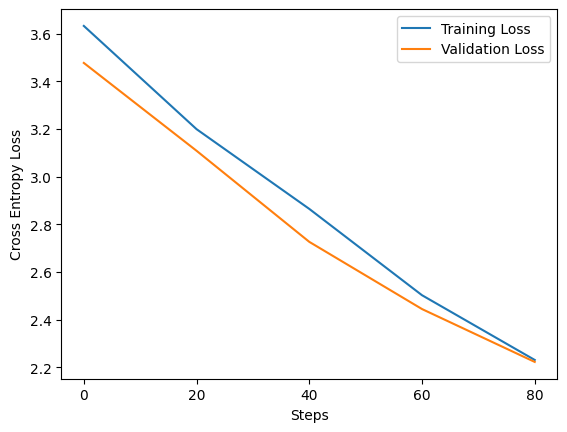

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
eval_losses = [t['eval_loss'] for t in trainer.state.log_history[20::21]]
train_losses = [t['loss'] for t in trainer.state.log_history[19::21]]
np.save(new_model + "/trainloss.npy", np.array(train_losses))
np.save(new_model + "/evalloss.npy", np.array(eval_losses))


plt.plot(train_losses, label="Training Loss")
plt.plot(eval_losses, label="Validation Loss")
plt.xlabel("Steps")
plt.xticks([0,1,2,3,4], [0,20, 40, 60, 80])
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()

In [ ]:
print(data[12])


You are a psychiatrist diagnosing a patient, describing what mental illness they have and discussing how to alleviate it, using information from the provided DSM snippet.

### DSM Snippet:
to depressive disorders, 
and recovery may be facilitated by antidepressant treatment

Major Depressive Disorder
Diagnostic Criteria
A. Five (or more) of the following symptoms have been present during the same 2-week
period and represent a change from previous functioning: at least one of the symptoms
is either (1) depressed mood or (2) loss of interest or pleasure.
Note: Do not include symptoms that are clearly attributable to another medical condition.
1. Depressed mood most of the day, nearly every day, as indicated by either subjective report (e.g., feels sad, empty, hopeless) or observation made by others (e.g.,
appears tearful). (Note: In children and adolescents, can be irritable mood.)
2. Markedly diminished interest or pleasure in all, or almost all, activities most of the
day, nearly eve

In [21]:
input = tokenizer(f'''You are a psychiatrist diagnosing a patient, describing what mental illness they have and discussing how to alleviate it, using information from the provided DSM snippet.

### DSM Snippet:
to depressive disorders,
and recovery may be facilitated by antidepressant treatment

Major Depressive Disorder
Diagnostic Criteria
A. Five (or more) of the following symptoms have been present during the same 2-week
period and represent a change from previous functioning: at least one of the symptoms
is either (1) depressed mood or (2) loss of interest or pleasure.
Note: Do not include symptoms that are clearly attributable to another medical condition.
1. Depressed mood most of the day, nearly every day, as indicated by either subjective report (e.g., feels sad, empty, hopeless) or observation made by others (e.g.,
appears tearful). (Note: In children and adolescents, can be irritable mood.)
2. Markedly diminished interest or pleasure in all, or almost all, activities most of the
day, nearly every day (as indicated by either subjective account or observation).
3. Significant weight loss when not dieting or weight gain (e.g., a change of more than
5% of body weight in a month), or

### Question:
I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

### Response:''', return_tensors='pt').to(device)
torch.manual_seed(70)

output = model.generate(**input, max_new_tokens=100, do_sample=True, temperature = 0.4, top_k=50, top_p=0.90, num_return_sequences=1)[0] #these hyperparams??? idk man
print(tokenizer.decode(output, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are a psychiatrist diagnosing a patient, describing what mental illness they have and discussing how to alleviate it, using information from the provided DSM snippet.

### DSM Snippet:
to depressive disorders,
and recovery may be facilitated by antidepressant treatment

Major Depressive Disorder
Diagnostic Criteria
A. Five (or more) of the following symptoms have been present during the same 2-week
period and represent a change from previous functioning: at least one of the symptoms
is either (1) depressed mood or (2) loss of interest or pleasure.
Note: Do not include symptoms that are clearly attributable to another medical condition.
1. Depressed mood most of the day, nearly every day, as indicated by either subjective report (e.g., feels sad, empty, hopeless) or observation made by others (e.g.,
appears tearful). (Note: In children and adolescents, can be irritable mood.)
2. Markedly diminished interest or pleasure in all, or almost all, activities most of the
day, nearly every

In [20]:
torch.manual_seed(70)
output = base_model.generate(**input, max_new_tokens=100, do_sample=True, temperature = 0.4, top_k=50, top_p=0.90, num_return_sequences=1)[0] #these hyperparams??? idk man
print(tokenizer.decode(output, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are a psychiatrist diagnosing a patient, describing what mental illness they have and discussing how to alleviate it, using information from the provided DSM snippet.

### DSM Snippet:
to depressive disorders,
and recovery may be facilitated by antidepressant treatment

Major Depressive Disorder
Diagnostic Criteria
A. Five (or more) of the following symptoms have been present during the same 2-week
period and represent a change from previous functioning: at least one of the symptoms
is either (1) depressed mood or (2) loss of interest or pleasure.
Note: Do not include symptoms that are clearly attributable to another medical condition.
1. Depressed mood most of the day, nearly every day, as indicated by either subjective report (e.g., feels sad, empty, hopeless) or observation made by others (e.g.,
appears tearful). (Note: In children and adolescents, can be irritable mood.)
2. Markedly diminished interest or pleasure in all, or almost all, activities most of the
day, nearly every